<a href="https://colab.research.google.com/github/elylaila/seminario/blob/main/bertita_adagrad_hyperparameter_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00


In [19]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Seminario

/content/drive/MyDrive/Seminario


In [5]:
df_dev = load_dataset("csv", data_files="dataset/df_train_clean.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [6]:
dev = df_dev['train'].train_test_split(test_size=0.3, seed=42)
dev

DatasetDict({
    train: Dataset({
        features: ['text', 'homotransphobic'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['text', 'homotransphobic'],
        num_rows: 1500
    })
})

In [9]:
df_train = dev["train"]
df_val = dev["test"]

In [10]:
df_train = df_train.rename_column("homotransphobic", "labels")
df_val = df_val.rename_column("homotransphobic", "labels")

In [11]:
df_val

Dataset({
    features: ['text', 'labels'],
    num_rows: 1500
})

# Model loading

In [13]:
nome = 'bert_base_italian'
model_name = 'dbmdz/bert-base-italian-cased'

In [14]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [15]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [16]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
# tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [17]:
tokenized_train

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3500
})

# Training

In [18]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [ ]:
def hyperparameter_search(model_name=model_name, optim='adagrad', learning_rate=0.00005, dropout=0.1):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned",
            evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=10,
            load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )
    config = AutoConfig.from_pretrained(model_name)
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    return training_args, model

In [ ]:
%%time
dropout_values = [0.05, 0.1]
lr_values = [0.00005, 0.00003, 0.00007]
histories = {}
for dropout_value in dropout_values:
  for lr_value in lr_values:
    training_args, model = hyperparameter_search(dropout=dropout_value, learning_rate=lr_value)
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_val,
      compute_metrics=compute_metrics)
    trainer.train()
    log_history = trainer.state.log_history
    histories[f'Dropout_{dropout_value}_lr_{lr_value}'] = log_history

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.678900,0.692070,0.362429
2,0.573100,0.595633,0.726586
3,0.526900,0.583143,0.722150
4,0.490200,0.629462,0.736806
5,0.465800,0.578770,0.756596
6,0.379800,0.649181,0.757106
7,0.399700,0.685777,0.757621
8,0.327500,0.699028,0.739393
9,0.281300,0.785475,0.754895
10,0.251200,0.892703,0.760449


CPU times: user 33min 38s, sys: 36.8 s, total: 34min 15s
Wall time: 37min 27s


In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name)

# Evaluation

In [ ]:
log_history = trainer.state.log_history

In [ ]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df_train = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, index=[0])
    df = pd.concat([df, df_train], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df_val = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, index=[0])
    df = pd.concat([df, df_val], ignore_index=True)
df

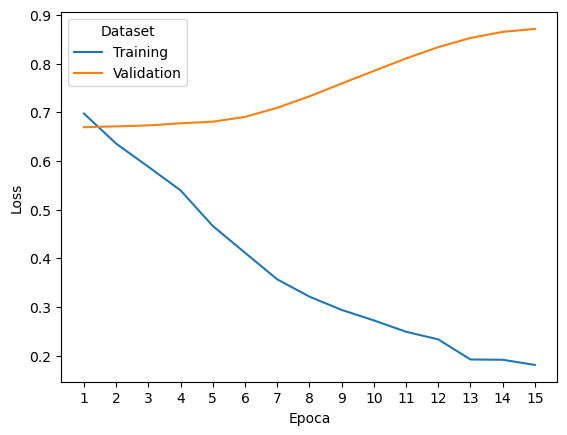

In [ ]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from transformers.modelcard import parse_log_history

In [ ]:
his = parse_log_history(log_history)

In [ ]:
df_his = pd.DataFrame(his[1], columns=['Step','Epoch', 'Training Loss', 'Validation Loss', 'F1'])

In [ ]:
df_his

In [ ]:
output_predictions = trainer.predict(tokenized_val)

In [ ]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

In [ ]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()